
# ЛР1 — Временные ряды (UCR: Wine, Yoga), Малышев Андрей, ШАД-311

- Загрузка датасетов
- EDA
- Обучение 1-NN (евклид) на TRAIN, оценка на TEST датасетах



In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [27]:
def load_ucr_split(train_file, test_file):
    """ Чтение train и test файлов в датасеты"""
    def read_any(path):
        df = pd.read_csv(path, header=None, sep=',', engine="python")
        df = df.dropna(axis=1, how="all")

        # первая колонка — метка, остальные — признаки
        y = df.iloc[:, 0].to_numpy()
        X = df.iloc[:, 1:].apply(pd.to_numeric, errors="coerce").to_numpy()

        y_num = pd.to_numeric(y, errors="raise")
        y = y_num.astype(int) if np.allclose(y_num, np.round(y_num)) else y_num
        return X, y

    X_train, y_train = read_any(train_file)
    X_test, y_test = read_any(test_file)

    print(f"OK: {train_file} -> X_train {X_train.shape}, {test_file} -> X_test {X_test.shape}")
    return X_train, y_train, X_test, y_test



def zscore_per_series(X, eps=1e-12):
    """ Z-нормировка по каждой строке """
    X = X.astype(float)
    m = X.mean(axis=1, keepdims=True)
    s = X.std(axis=1, keepdims=True)
    return (X - m) / (s + eps)

def show_examples_by_class(Xz, y, title, n_per_class=1):
    classes = np.unique(y)
    plt.figure(figsize=(10,4))
    for c in classes:
        idx = np.where(y == c)[0][:n_per_class]
        for i in idx:
            plt.plot(Xz[i], label=f"class {c}")
    plt.title(f"{title}: примеры рядов по классам")
    plt.xlabel("t"); plt.ylabel("x(t), z-score")
    # Удалим дубликаты легенды
    handles, labels = plt.gca().get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    if uniq:
        plt.legend(uniq.values(), uniq.keys(), loc="best")
    plt.show()

def show_mean_std_by_class(Xz, y, title):
    classes = np.unique(y)
    t = np.arange(Xz.shape[1])
    plt.figure(figsize=(10,4))
    for c in classes:
        Xc = Xz[y == c]
        m = Xc.mean(axis=0)
        s = Xc.std(axis=0)
        plt.plot(t, m, label=f"class {c} mean")
        plt.fill_between(t, m - s, m + s, alpha=0.2)
    plt.title(f"{title}: среднее ± eps по классам")
    plt.xlabel("t"); plt.ylabel("x(t), z-score")
    plt.legend(loc="best")
    plt.show()

def fit_eval_knn(X_train, y_train, X_test, y_test, title):
    # Z-нормируем по строкам и train, и test
    X_train_z = zscore_per_series(X_train)
    X_test_z  = zscore_per_series(X_test)
    # 1-NN с евклидовой метрикой
    knn = KNeighborsClassifier(n_neighbors=1, metric="euclidean")
    knn.fit(X_train_z, y_train)
    y_pred = knn.predict(X_test_z)

    print("-"*60)
    print(f"[TEST] {title} — 1-NN (евклид)")
    print("Accuracy:", f"{accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

    # Матрица ошибок (matplotlib, без seaborn)
    labels = np.unique(np.concatenate([y_train, y_test]))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{title}: Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=0)
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center')
    plt.colorbar()
    plt.tight_layout()
    plt.show()


OK: ./Wine_TRAIN -> X_train (57, 234), ./Wine_TEST -> X_test (54, 234)
WINE shapes: (57, 234) (54, 234)
WINE classes TRAIN: {np.int64(1): np.int64(30), np.int64(2): np.int64(27)}
WINE classes TEST : {np.int64(1): np.int64(27), np.int64(2): np.int64(27)}


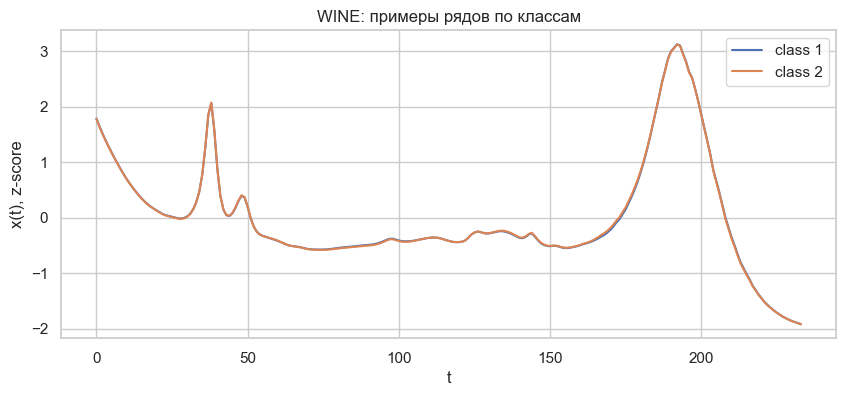

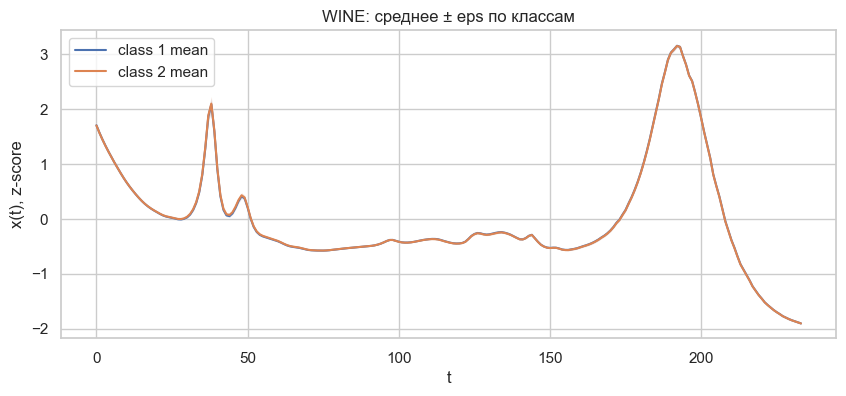

------------------------------------------------------------
[TEST] WINE — 1-NN (евклид)
Accuracy: 0.6111

Classification report:
               precision    recall  f1-score   support

           1     0.6154    0.5926    0.6038        27
           2     0.6071    0.6296    0.6182        27

    accuracy                         0.6111        54
   macro avg     0.6113    0.6111    0.6110        54
weighted avg     0.6113    0.6111    0.6110        54



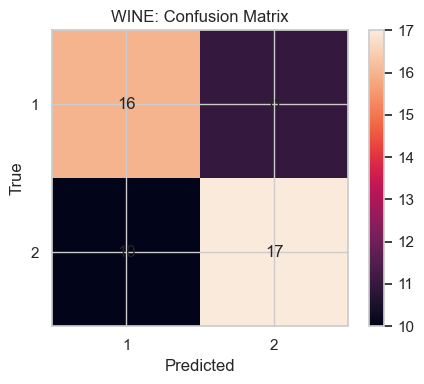

In [28]:
# WINE dataset
Xtr_wine, ytr_wine, Xte_wine, yte_wine = load_ucr_split("./Wine_TRAIN", "./Wine_TEST")
print("WINE shapes:", Xtr_wine.shape, Xte_wine.shape)
print("WINE classes TRAIN:", dict(zip(*np.unique(ytr_wine, return_counts=True))))
print("WINE classes TEST :",  dict(zip(*np.unique(yte_wine, return_counts=True))))

Xall_wine_z = zscore_per_series(np.vstack([Xtr_wine, Xte_wine]))
yall_wine = np.concatenate([ytr_wine, yte_wine])
show_examples_by_class(Xall_wine_z, yall_wine, title="WINE", n_per_class=1)
show_mean_std_by_class(Xall_wine_z, yall_wine, title="WINE")
fit_eval_knn(Xtr_wine, ytr_wine, Xte_wine, yte_wine, title="WINE")


OK: ./yoga_TRAIN -> X_train (300, 426), ./yoga_TEST -> X_test (3000, 426)
YOGA shapes: (300, 426) (3000, 426)
YOGA classes TRAIN: {np.int64(1): np.int64(137), np.int64(2): np.int64(163)}
YOGA classes TEST : {np.int64(1): np.int64(1393), np.int64(2): np.int64(1607)}


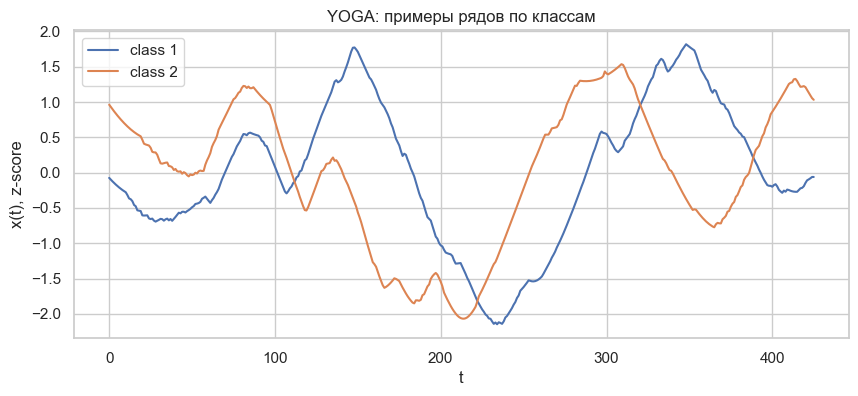

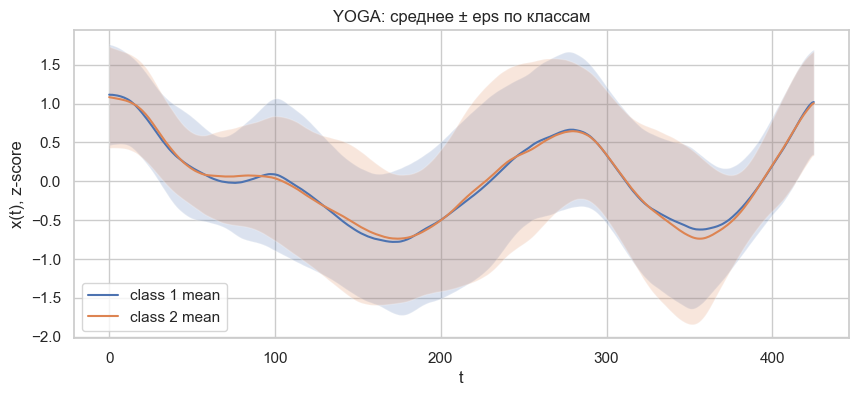

------------------------------------------------------------
[TEST] YOGA — 1-NN (евклид)
Accuracy: 0.8303

Classification report:
               precision    recall  f1-score   support

           1     0.8369    0.7882    0.8118      1393
           2     0.8252    0.8668    0.8455      1607

    accuracy                         0.8303      3000
   macro avg     0.8311    0.8275    0.8287      3000
weighted avg     0.8306    0.8303    0.8299      3000



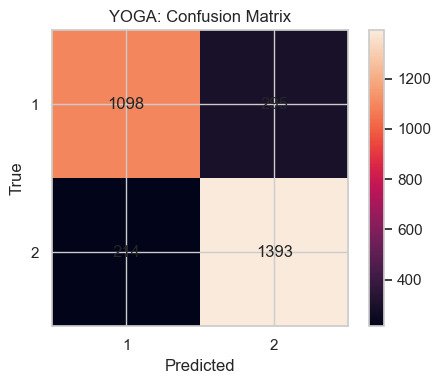

In [29]:
# YOGA dataset
Xtr_yoga, ytr_yoga, Xte_yoga, yte_yoga = load_ucr_split("./yoga_TRAIN", "./yoga_TEST")
print("YOGA shapes:", Xtr_yoga.shape, Xte_yoga.shape)
print("YOGA classes TRAIN:", dict(zip(*np.unique(ytr_yoga, return_counts=True))))
print("YOGA classes TEST :",  dict(zip(*np.unique(yte_yoga, return_counts=True))))

Xall_yoga_z = zscore_per_series(np.vstack([Xtr_yoga, Xte_yoga]))
yall_yoga = np.concatenate([ytr_yoga, yte_yoga])
show_examples_by_class(Xall_yoga_z, yall_yoga, title="YOGA", n_per_class=1)
show_mean_std_by_class(Xall_yoga_z, yall_yoga, title="YOGA")
fit_eval_knn(Xtr_yoga, ytr_yoga, Xte_yoga, yte_yoga, title="YOGA")


# Заключение и интерпретация

На датасете Wine результат получился средний — около 61% точности. Это связано с тем, что выборка маленькая, а сами ряды двух классов похожи между собой, поэтому простая метрика расстояний часто путается.

На датасете Yoga модель сработала гораздо лучше — точность около 83%. Здесь рядов больше, классы различимы, и даже самый простой метод 1-NN показывает хороший результат.

В итоге видно, что качество сильно зависит от свойств данных: где выборка маленькая и классы близки — простой подход не вытягивает; где данных много и они отличаются — даже базовый метод работает неплохо.